# Screening

Packages are included in the requirements file.

1. Automatic filtering to avoid Scopus indexing
2. TAK column

This notebook provides some examples to filter data on the initial Scopus dataset.
Only custom files.

## Paths

In [1]:
import os

ROOT_PATH = os.getcwd()
print(ROOT_PATH)

/home/jovyan/work


In [4]:
# Public
PUB_DATASET_SUMMARY_PATH = os.path.join(ROOT_PATH, 'data/results/screening/summary.csv')
print(PUB_DATASET_SUMMARY_PATH)

/home/jovyan/work/data/results/screening/summary.csv


## Summary

In [5]:
import pandas as pd

summary_df = pd.read_csv(PUB_DATASET_SUMMARY_PATH)
summary_df

,operation,type,nb rows
0,Load dataset,NaN,3366
1,Remove N/A abstract,automatic,4
2,Remove N/A references,automatic,18
3,Remove N/A document type,automatic,0
4,Remove no query terms in TAK,manual,22
5,Remove review papers,manual,41
6,Remove out of scope,manual,88
7,Remove not more popular,manual,2302
8,Remove no more connected,manual,11
9,Export dataset,NaN,880


## Detailed Process (private)
Running this process until here require the private dataset.

The private dataset contains a filtering column.

### Imports

In [8]:
from dataset_analysis.filtering.dataset_filter_processor import DatasetFilterProcessor
from dataset_analysis.filtering.pred_filter import PredefinedFilter

### Paths

In [16]:
# Private
#Input
PRIV_DATASET_PATH = os.path.join(ROOT_PATH, 'data/private/scopus_bib_prisma_2010-2022.xlsx')
# Output
OUT_MENTION_PVI = os.path.join(ROOT_PATH, 'data/private/screening/mentionPVI.xlsx')
OUT_NO_MENTION_PVI = os.path.join(ROOT_PATH, 'data/private/screening/no-mentionPVI.xlsx')
EXCLUDED_DOI_FILEPATH = os.path.join(ROOT_PATH, 'data/private/screening/excluded-doi.xlsx')
FIG_FOLDER_PATH = os.path.join(ROOT_PATH, 'data/private/screening/')
FIG_NAME = 'BLV_query_terms_TAK'

### Summary

In [17]:
# Filtering configuration
auto_remove_noquery_filter = PredefinedFilter(operation='Remove no query terms in TAK', column_name='Filtered', flag='3d') 
remove_revpaper_filter = PredefinedFilter(operation='Remove review papers', column_name='Filtered', flag='4a')
remove_out_scope_filter = PredefinedFilter(operation='Remove out of scope', column_name='Filtered', flag='4b')
remove_outliers_filter = PredefinedFilter(operation='Remove not more popular', column_name='Filtered', flag='5a')
remove_unconnected_filter = PredefinedFilter(operation='Remove no more connected', column_name='Filtered', flag='5b')
predefined_filters = [auto_remove_noquery_filter, remove_revpaper_filter, remove_out_scope_filter, remove_outliers_filter, remove_unconnected_filter]

filter = DatasetFilterProcessor(scopus_dataset=PRIV_DATASET_PATH, predefined_filters=predefined_filters)
filter.process()
print(filter.summary())

                      operation       type  nb rows
0                  Load dataset        N/A     3366
1           Remove N/A abstract  automatic        4
2         Remove N/A references  automatic       18
3      Remove N/A document type  automatic        0
4  Remove no query terms in TAK     manual       22
5          Remove review papers     manual       41
6           Remove out of scope     manual       88
7       Remove not more popular     manual     2302
8      Remove no more connected     manual       11
9                Export dataset        N/A      880


### Check if query terms are in TAK

Scopus search terms:

> "visually impaired", "with vis* impair*", "with vis* disabilit*",
"eye disorder*", "vis* disorder*", "partially sighted",
"blind people", "blind person*", "blind user*", "with blindness", "deafblind", "deaf-blind", "low vision people", "low vision person*", "low vision user*", "with low vision"

In [18]:
from dataset_analysis.analyzer_utils import regexp_counter_analysis

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)

REGEXP_SEARCH_TERMS = [
    ('VI', r'(visually[ |-]impaired ?\w*)'),
    ('PVI', r'(\w* with vis[a-z-]* impair[a-z-]*)'),
    ("PVD", r'(\w* with vis[a-z-]* disabilit[a-z-]*)'),
    ("ED", r'(eye disorders?)'),
    ("VD", r'(vis[a-z-]* disorders?)'),
    ("PS", r'(partially sighted)'),
    ("PB", r'(\w* with blindness)'),
    ("DB", r'(deaf[ |-]?blind[a-z-]*)'),
    ("PV", r'(partial vision)'),
    ("BP", r'(blind people|blind persons?|blind users?)'),
    ("B", r'(blind)'),
    ("LVP", r'(low[ |-]vision people|low[ |-]vision persons?|low[ |-]vision users?)'),
    ("PLV", r'(\w* with low[ |-]vision)')
]

SEARCH_IN = 'TAK'

                  operation       type  nb rows
0              Load dataset        N/A     3366
1       Remove N/A abstract  automatic        4
2     Remove N/A references  automatic       18
3  Remove N/A document type  automatic        0
4            Export dataset        N/A     3344
Patterns: (?P<VI>(visually[ |-]impaired ?\w*))|(?P<PVI>(\w* with vis[a-z-]* impair[a-z-]*))|(?P<PVD>(\w* with vis[a-z-]* disabilit[a-z-]*))|(?P<ED>(eye disorders?))|(?P<VD>(vis[a-z-]* disorders?))|(?P<PS>(partially sighted))|(?P<PB>(\w* with blindness))|(?P<DB>(deaf[ |-]?blind[a-z-]*))|(?P<PV>(partial vision))|(?P<BP>(blind people|blind persons?|blind users?))|(?P<B>(blind))|(?P<LVP>(low[ |-]vision people|low[ |-]vision persons?|low[ |-]vision users?))|(?P<PLV>(\w* with low[ |-]vision))
keyword                              DOI  B  BP  DB  ED  LVP  PB  PLV  PS  PV  PVD  PVI  VD  VI  Totals
0           10.1007/978-3-319-07455-9_34  1   2   0   0    0   0    0   0   0    0    0   0   0       3
1           

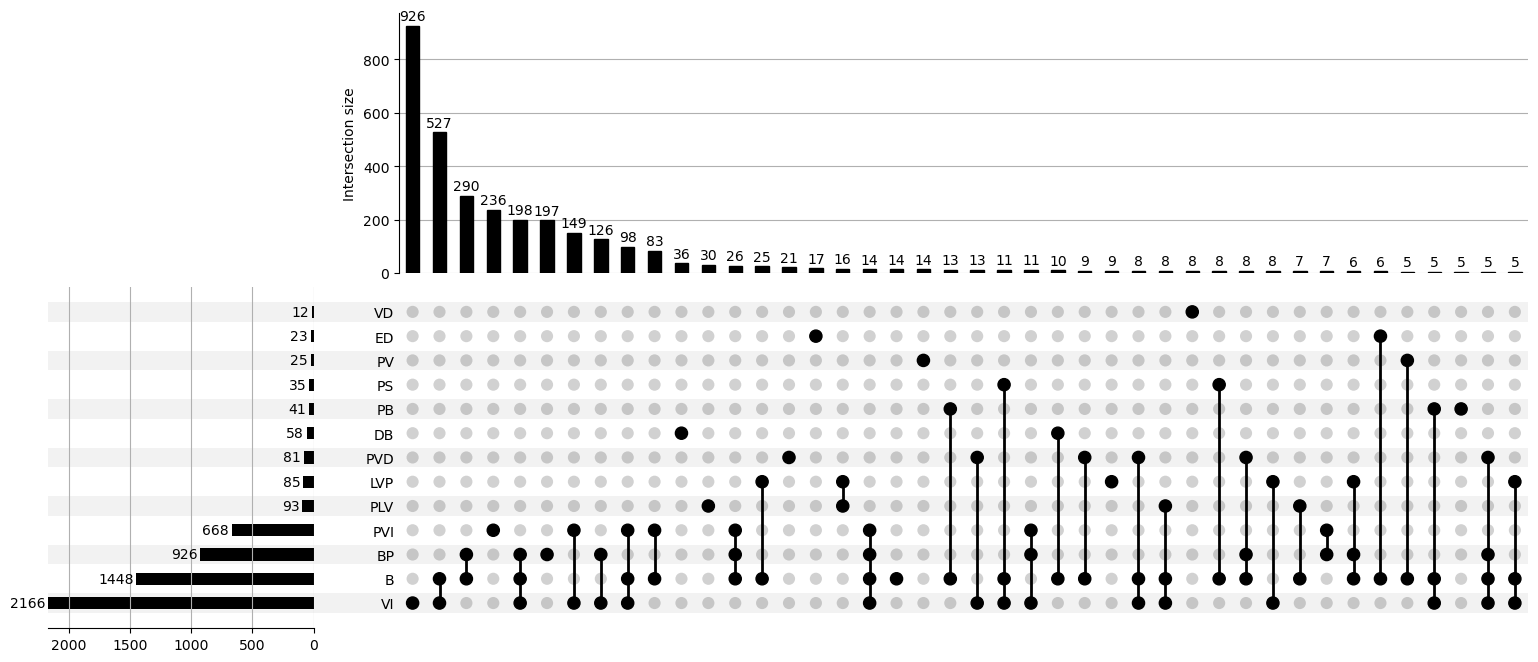

In [19]:
# Automatic filtering without predefined filter
filter = DatasetFilterProcessor(scopus_dataset=PRIV_DATASET_PATH, predefined_filters=[])
filter.process()
print(filter.summary())

regexp_counter_analysis(df=filter.get_df(),
                        keywords_search_spec=REGEXP_SEARCH_TERMS,
                        search_in=SEARCH_IN,
                        out_filepath=OUT_MENTION_PVI,
                        excluded_out_filepath=OUT_NO_MENTION_PVI,
                        figname=FIG_NAME,
                        fig_folder_path=FIG_FOLDER_PATH)